In [ ]:
# # !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [ ]:
# !kaggle datasets download -d salader/dogs-vs-cats

 99% 1.06G/1.06G [00:07<00:00, 141MB/s]
100% 1.06G/1.06G [00:07<00:00, 162MB/s]


In [1]:
# import zipfile
# zip_ref = zipfile.ZipFile('/input/content/monkeypox.zip', 'r')
# zip_ref.extractall('/kaggle/working/monkeypox')
# zip_ref.close()

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import keras_tuner as kt
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns

2025-07-06 17:23:33.714957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751822613.883849      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751822613.936617      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
conv_base = InceptionV3(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

I0000 00:00:1751822631.196694      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751822631.197457      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [4]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6  # Minimum learning rate
)

In [5]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define data augmentation as a keras Sequential model
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),  # Increase rotation
    layers.RandomZoom(0.3),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.2),  # Add contrast adjustment
    layers.RandomBrightness(0.2)  # Add brightness adjustment
])
# Load datasets from your directories (with your exact paths)
train_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/content/Fold1/Fold1/Fold1/Train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/content/Fold1/Fold1/Fold1/Val',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)

# Function to apply augmentation and normalization to training data
def process_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    image = data_augmentation(image)            # Apply augmentation
    return image, label

# Function to normalize validation data only
def process_val(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

# Apply the processing functions
train_ds = train_ds.map(process_train, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(process_val, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(tf.data.AUTOTUNE)

Found 2142 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


In [ ]:
# import os
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# import keras_tuner as kt
# import json
# import pickle
# import shutil

# # Create output directory for autosaving
# output_dir = '/kaggle/working/inceptionv3_models/'
# os.makedirs(output_dir, exist_ok=True)

# # Assuming conv_base, train_ds, validation_ds are defined
# # Unfreeze top 30 layers of InceptionV3
# conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# for layer in conv_base.layers[-30:]:
#     layer.trainable = True

# # Custom callback to save model weights and trial data after each trial
# class AutosaveCallback(tf.keras.callbacks.Callback):
#     def __init__(self, output_dir, tuner):
#         super().__init__()
#         self.output_dir = output_dir
#         self.tuner = tuner
    
#     def on_epoch_end(self, epoch, logs=None):
#         # Save trial model weights and data at the end of each epoch
#         trial_id = self.tuner.oracle.ongoing_trial.trial_id
#         trial_model = self.model
#         trial_model.save_weights(os.path.join(self.output_dir, f'trial_{trial_id}_epoch_{epoch+1}_weights.weights.h5'))
        
#         # Save trial hyperparameters
#         trial_hps = self.tuner.oracle.get_trial(trial_id).hyperparameters.values
#         with open(os.path.join(self.output_dir, f'trial_{trial_id}_hyperparameters.json'), 'w') as f:
#             json.dump(trial_hps, f, indent=4)
        
#         # Save trial metrics
#         trial_metrics = self.tuner.oracle.get_trial(trial_id).metrics.get_history()
#         with open(os.path.join(self.output_dir, f'trial_{trial_id}_metrics.pkl'), 'wb') as f:
#             pickle.dump(trial_metrics, f)

# # Define model-building function
# def build_model(hp):
#     model = Sequential()
#     model.add(conv_base)
#     model.add(GlobalAveragePooling2D())
#     model.add(Dense(
#         units=hp.Int('units', min_value=128, max_value=512, step=128),
#         activation='relu'
#     ))
#     model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(
#         optimizer=keras.optimizers.Adam(
#             hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')
#         ),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# # Initialize Keras Tuner with checkpointing
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=20,
#     directory=output_dir + 'tuner_dir',
#     project_name='inceptionv3_tuning',
#     overwrite=False  # Resume from checkpoint if exists
# )

# # Define callbacks for autosaving
# autosave_callback = AutosaveCallback(output_dir, tuner)
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     os.path.join(output_dir, 'checkpoint_best_model.keras'),
#     monitor='val_accuracy',
#     save_best_only=True,
#     mode='max'
# )

# # Perform hyperparameter search with autosaving
# tuner.search(
#     train_ds,
#     validation_data=validation_ds,
#     epochs=20,
#     callbacks=[autosave_callback, checkpoint_callback]
# )

# # Save best model
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.save(os.path.join(output_dir, 'best_model.keras'))
# best_model.save_weights(os.path.join(output_dir, 'best_model_weights.weights.h5'))

# # Save best hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# with open(os.path.join(output_dir, 'best_hyperparameters.json'), 'w') as f:
#     json.dump(best_hps.values, f, indent=4)

# # Save trials summary
# trials_summary = [
#     {
#         'trial_id': trial.trial_id,
#         'hyperparameters': trial.hyperparameters.values,
#         'score': trial.score,
#         'status': trial.status
#     } for trial in tuner.oracle.trials.values()
# ]
# with open(os.path.join(output_dir, 'trials_summary.json'), 'w') as f:
#     json.dump(trials_summary, f, indent=4)

# # Save trials history for top 5 trials
# best_trials = tuner.oracle.get_best_trials(num_trials=5)
# trials_history = {trial.trial_id: trial.metrics.get_history() for trial in best_trials}
# with open(os.path.join(output_dir, 'trials_history.pkl'), 'wb') as f:
#     pickle.dump(trials_history, f)

# # Create ZIP archive for backup
# shutil.make_archive('/kaggle/working/inceptionv3_models', 'zip', output_dir)
# print("All files saved in autosave mode in", output_dir)
# print("ZIP archive created at /kaggle/working/inceptionv3_models.zip")

In [6]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3



# Unfreeze top 20 layers of InceptionV3
# for layer in conv_base.layers[-20:]:
#     layer.trainable = True

# Freeze all layers initially
conv_base.trainable = False

def build_model(hp):
    model = Sequential()
    model.add(conv_base)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(
        units=hp.Int('units', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=12,
    directory='tuner_dir',
    project_name='inceptionv3_tuning'
)
tuner.search(train_ds, validation_data=validation_ds, epochs=12)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 03m 49s]
val_accuracy: 0.5976190567016602

Best val_accuracy So Far: 0.8500000238418579
Total elapsed time: 00h 53m 41s


In [10]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint
# Optional: Get the best hyperparameters for reference
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Create output directory
output_dir = '/kaggle/working/inceptionv3_models/'
os.makedirs(output_dir, exist_ok=True)
best_model.save(os.path.join(output_dir, 'best_model.keras'))
best_model.save_weights(os.path.join(output_dir, 'best_model_weights.weights.h5'))
print(f"Best units: {best_hps.get('units')}")
print(f"Best dropout: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Define callbacks for further training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_finetuned_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Optional: Compute class weights for imbalanced data
from sklearn.utils import class_weight
import numpy as np
y_train = np.concatenate([labels.numpy() for _, labels in train_ds])
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = dict(enumerate(class_weights))

# Further train the best model
history = best_model.fit(
    train_ds,
    epochs=50,  # Train for more epochs
    validation_data=validation_ds,
    class_weight=class_weights,  # Apply class weights if needed
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Evaluate the model on test dataset
# loss, accuracy = best_model.evaluate(test_ds)
# print(f"Test Loss: {loss:.4f}")
# print(f"Test Accuracy: {accuracy:.4f}")

Best units: 512
Best dropout: 0.30000000000000004
Best learning rate: 9.635513804323065e-05
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 246ms/step - accuracy: 0.5275 - loss: 0.7051 - val_accuracy: 0.7667 - val_loss: 0.5396 - learning_rate: 1.9271e-05
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 243ms/step - accuracy: 0.4934 - loss: 0.6956 - val_accuracy: 0.7952 - val_loss: 0.5322 - learning_rate: 1.9271e-05
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 327ms/step - accuracy: 0.4894 - loss: 0.6954 - val_accuracy: 0.8357 - val_loss: 0.5175 - learning_rate: 1.9271e-05
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step - accuracy: 0.4877 - loss: 0.6950 - val_accuracy: 0.7738 - val_loss: 0.5342 - learning_rate: 1.9271e-05
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - accuracy: 0.4857 - loss: 0.6945 - val_accuracy: 0.8571 - val_loss: 0.5052 - learning_rate: 1.9271e-05
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.5031 - loss: 0.6924 - val_accuracy: 0.8452 - val_loss: 0

In [13]:

import json
import pickle

# Save best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
with open(os.path.join(output_dir, 'best_hyperparameters.json'), 'w') as f:
    json.dump(best_hps.values, f, indent=4)

# Save trials summary
trials_summary = [
    {
        'trial_id': trial.trial_id,
        'hyperparameters': trial.hyperparameters.values,
        'score': trial.score,
        'status': trial.status
    } for trial in tuner.oracle.trials.values()
]
with open(os.path.join(output_dir, 'trials_summary.json'), 'w') as f:
    json.dump(trials_summary, f, indent=4)

# Save training history
with open(os.path.join(output_dir, 'training_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

# Save trials history
best_trials = tuner.oracle.get_best_trials(num_trials=5)
trials_history = {trial.trial_id: trial.metrics.get_history() for trial in best_trials}
with open(os.path.join(output_dir, 'trials_history.pkl'), 'wb') as f:
    pickle.dump(trials_history, f)

# Create ZIP archive
shutil.make_archive('/kaggle/working/inceptionv3_models', 'zip', output_dir)
print("All files saved in", output_dir)
print("ZIP archive created at /kaggle/working/inceptionv3_models.zip")

TypeError: MetricsTracker.get_history() missing 1 required positional argument: 'name'

In [14]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,951,589 (95.18 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 2,099,204 (8.01 MB)

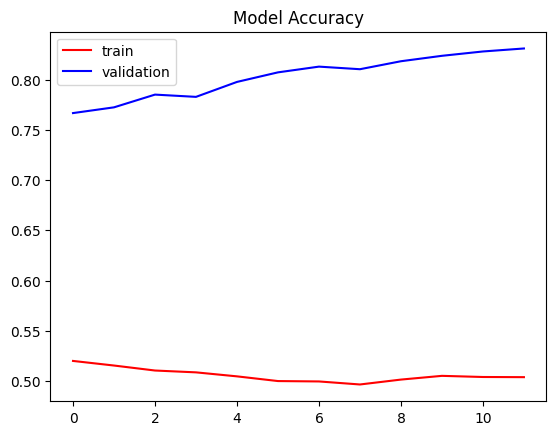

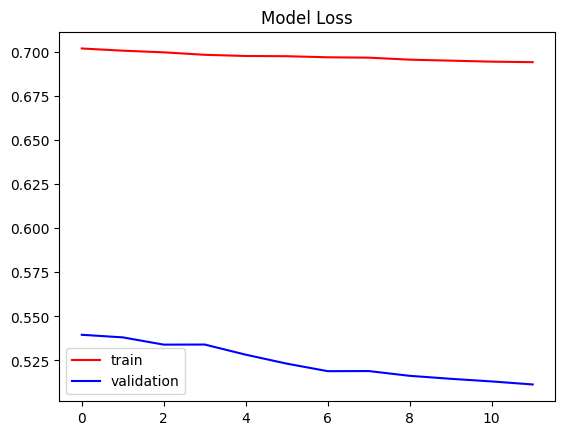

In [17]:
import matplotlib.pyplot as plt
# Plot training curves
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

plt.plot(smooth_curve(history.history['accuracy']), color='red', label='train')
plt.plot(smooth_curve(history.history['val_accuracy']), color='blue', label='validation')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.plot(smooth_curve(history.history['loss']), color='red', label='train')
plt.plot(smooth_curve(history.history['val_loss']), color='blue', label='validation')
plt.title('Model Loss')
plt.legend()
plt.show()

Found 2142 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


In [22]:
# Load the Validation Dataset

from tensorflow.keras.utils import image_dataset_from_directory

test_dir = '/kaggle/input/content/Fold1/Fold1/Fold1/Test'

test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150, 150)
)
# Evaluate the model on test dataset
loss, accuracy = best_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Found 45 files belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.4169 - loss: 3.6183
Test Loss: 3.7896
Test Accuracy: 0.4222


In [24]:
# Evaluate on test set
loss, accuracy = best_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4273 - loss: 3.7862
Test Loss: 3.7896
Test Accuracy: 0.4222


In [27]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score

# Classification report and AUC
y_true = []
y_pred_probs = []

# Resize images to (224, 224) to match InceptionV3 input requirements
def resize_image(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize to (224, 224)
    return image, label

# Apply resizing to the test dataset
test_ds_resized = test_ds.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)

# Predict on resized test dataset
for images, labels in test_ds_resized:
    preds = best_model.predict(images).flatten()  # Predict probabilities
    y_true.extend(labels.numpy())  # True labels
    y_pred_probs.extend(preds)     # Predicted probabilities

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Classification report
class_names = test_ds.class_names
print(classification_report(y_true, (y_pred_probs > 0.5).astype(int), target_names=class_names))

# AUC-ROC
auc = roc_auc_score(y_true, y_pred_probs)
print(f"AUC-ROC: {auc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
              precision    recall  f1-score   support

   Monkeypox       0.38      0.60      0.46        20
      Others       0.38      0.20      0.26        25

    accuracy                           0.38        45
   macro avg       0.38      0.40      0.36        45
weighted avg       0.38      0.38      0.35        45

AUC-ROC: 0.4660


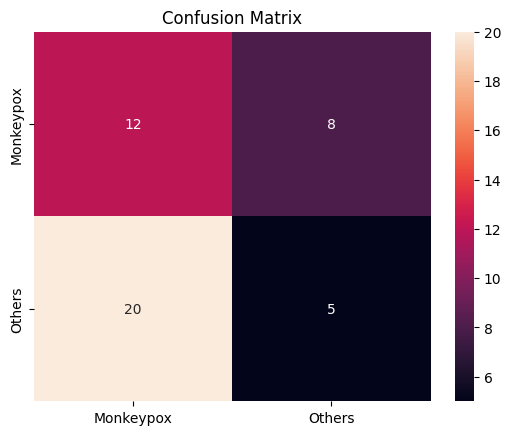

In [28]:
# Confusion matrix
cm = confusion_matrix(y_true, (np.array(y_pred_probs) > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in validation_ds:
    preds = model.predict(images).flatten()
    pred_labels = (preds > 0.5).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels)
class_name=["monkeypox","others"]
class_names = validation_ds.class_names  # ['monkeypox', 'others']

print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
# Load the Validation Dataset

from tensorflow.keras.utils import image_dataset_from_directory

test_dir = '/content/Fold1/Fold1/Fold1/Test'

test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)
# Normalize images
def preprocess(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:
import os
from collections import Counter

train_dir = "/content/Fold1/Fold1/Fold1/Train"
print("Train class counts:")
for label in os.listdir(train_dir):
    count = len(os.listdir(os.path.join(train_dir, label)))
    print(f"{label}: {count}")


Train class counts:
Others: 1162
Monkeypox: 980
